# Adversarial Attacks on Legal-Domain NER

In this notebook, we evaluate the vulnerability of a Portuguese legal-domain NER model
under *targeted adversarial attacks*. Unlike the robustness evaluation (Stage 2),
which focused on broad perturbation scenarios, here we design **controlled,
entity-aware attacks** to probe *where* and *why* the model fails.

We consider both:
- **Oracle-guided attacks**, using gold entity spans, and
- **Prediction-guided attacks**, using the model’s own baseline predictions.

This distinction allows us to assess not only worst-case vulnerability, but also
realistic failure modes at inference time.


## Oracle vs Prediction-Guided Attacks

For each attack, we evaluate two variants:

- **Oracle**: entity spans are derived from gold labels.
- **Pred**: entity spans are derived from baseline model predictions.

Oracle attacks represent an upper bound on adversarial effectiveness,
while prediction-guided attacks reflect what is feasible without access
to ground-truth annotations.

Comparing both reveals how much attack success depends on *perfect*
knowledge of entity boundaries.


## Why Word Insertion Requires a Separate Evaluation Protocol

Word insertion attacks fundamentally alter sequence length and token alignment.
As a result, standard token-aligned metrics (entity flip rate, span miss rate,
confidence drop via projection) are **not well-defined**.

To address this, we introduce a **true insertion evaluation protocol** that:
- does NOT project predictions back to the original sequence,
- measures **entity retention rate** in the attacked sequence, and
- measures **confidence drop at the true post-insertion token positions**.

This explains why some metrics appear as NaN for insertion attacks in the summary table.
These NaNs indicate *non-applicability*, not missing computations.


## Experimental Setup (Reproducibility)
- **Dataset**: LeNER-Br validation subset (`val_subset`), first *N* examples (same as Stage 2 for comparability).
- **Model**: fine-tuned Portuguese BERT for token classification (same checkpoint as Stages 2–3).
- **Inference**: sliding-window over word-level tokens to avoid truncation:
  - `MAX_LENGTH = {MAX_LENGTH}`, `STRIDE = {STRIDE}`
  - logits for overlapping words are **averaged** before `argmax`.
- **Randomness control**: fixed seeds for `random`, `numpy`, and `torch` (see cell below).
- **Attack intensity**:
  - char-typo probability `p = 0.5` inside entity spans
  - insertion probability `p = 0.5` near span boundaries

In [187]:
import os
import random
import string
from typing import Callable, Dict, List, Tuple

import numpy as np
import pandas as pd
import torch
import matplotlib.pyplot as plt
from datasets import load_dataset
from seqeval.metrics import precision_score, recall_score, f1_score
from seqeval.metrics.sequence_labeling import get_entities
from transformers import AutoModelForTokenClassification, AutoTokenizer

plt.rcParams['figure.figsize'] = (8, 4)

SEED = 42
EVAL_SIZE = 200
MAX_LENGTH = 256
STRIDE = 64

random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(SEED)

device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(f'Using device: {device}')



Using device: cuda


In [188]:
# Load dataset

dataset_id = 'peluz/lener_br'
hf_token = os.getenv('HF_TOKEN')
lener = load_dataset(dataset_id, token=hf_token)

ner_feature = lener['train'].features['ner_tags']
label_list = ner_feature.feature.names
id2label = {i: l for i, l in enumerate(label_list)}
label2id = {l: i for i, l in enumerate(label_list)}

val_subset = lener['validation'].select(range(EVAL_SIZE))
print(val_subset)
print('Labels:', label_list)



c:\Users\diogo\Repositorios\ner_smalllm_project\.venv\Lib\site-packages\datasets\load.py:1461: FutureWarning: The repository for peluz/lener_br contains custom code which must be executed to correctly load the dataset. You can inspect the repository content at https://hf.co/datasets/peluz/lener_br
You can avoid this message in future by passing the argument `trust_remote_code=True`.
Passing `trust_remote_code=True` will be mandatory to load this dataset from the next major release of `datasets`.
  warnings.warn(


Dataset({
    features: ['id', 'tokens', 'ner_tags'],
    num_rows: 200
})
Labels: ['O', 'B-ORGANIZACAO', 'I-ORGANIZACAO', 'B-PESSOA', 'I-PESSOA', 'B-TEMPO', 'I-TEMPO', 'B-LOCAL', 'I-LOCAL', 'B-LEGISLACAO', 'I-LEGISLACAO', 'B-JURISPRUDENCIA', 'I-JURISPRUDENCIA']


In [189]:
# Load fine-tuned model and tokenizer
model_dir = r"C:\Users\diogo\Repositorios\ner_smalllm_project\notebooks\models\lenerbr_bert_base"

model = AutoModelForTokenClassification.from_pretrained(model_dir)
model.config.id2label = id2label
model.config.label2id = label2id
model.to(device)
model.eval()

tokenizer = AutoTokenizer.from_pretrained(model_dir)
num_labels = model.config.num_labels

## Helper utilities

In [ ]:
def get_gold_labels(example) -> List[str]:
    return [label_list[t] for t in example['ner_tags']]


def get_spans(labels: List[str]) -> List[Tuple[str, int, int]]:
    """Return spans as (type, start, end) inclusive for BIO labels (defensive)."""
    spans = []
    ent_type = None
    start = None

    for i, tag in enumerate(labels):
        if tag.startswith("B-"):
            # close previous span if open
            if ent_type is not None:
                spans.append((ent_type, start, i - 1))
            ent_type = tag[2:]
            start = i

        elif tag.startswith("I-"):
            if ent_type is None:
                continue

            # If entity type changes inside span, close and start new (defensive)
            if tag[2:] != ent_type:
                spans.append((ent_type, start, i - 1))
                ent_type = tag[2:]
                start = i

        else:  # "O"
            if ent_type is not None:
                spans.append((ent_type, start, i - 1))
                ent_type = None
                start = None

    if ent_type is not None:
        spans.append((ent_type, start, len(labels) - 1))

    return spans


def spans_from_gold(example) -> List[Tuple[str, int, int]]:
    return get_spans(get_gold_labels(example))


def spans_from_pred(tokens: List[str], pred_labels: List[str]) -> List[Tuple[str, int, int]]:
    return get_spans(pred_labels)

## Metrics (Why these?)
Beyond seqeval Precision/Recall/F1, we report **attack-specific diagnostics**:

- **Entity flip rate**: among gold entity tokens that were correct at baseline, how often the attack turns them wrong.
- **Span miss rate (strict)**: fraction of gold spans not recovered exactly as (TYPE, start, end).
- **Span token error rate**: fraction of gold spans where at least one token label inside the span is wrong.
- **Confidence drop (gold/pred)**: average logit drop for the gold class or the baseline predicted class.


## Sliding-window prediction (no truncation mismatches)
Overlapping windows with stride cover long sequences; logits for shared words are averaged before argmax.


In [ ]:
def predict_word_logits(tokens: List[str]) -> np.ndarray:
    """Aggregate logits over sliding windows. Returns (n_words, num_labels)."""
    model.eval()  # disables dropout for stable/reproducible logits

    encoding = tokenizer(
        tokens,
        is_split_into_words=True,
        return_overflowing_tokens=True,
        stride=STRIDE,
        truncation=True,
        max_length=MAX_LENGTH,
        return_tensors=None,
        padding=False,
    )

    n_words = len(tokens)
    agg = np.zeros((n_words, num_labels), dtype=np.float32)
    counts = np.zeros(n_words, dtype=np.float32)

    for i in range(len(encoding["input_ids"])):
        input_ids = torch.tensor(encoding["input_ids"][i]).unsqueeze(0).to(device)
        attention_mask = (
            torch.tensor(encoding["attention_mask"][i]).unsqueeze(0).to(device)
        )
        word_ids = encoding.word_ids(i)

        with torch.no_grad():
            outputs = model(input_ids=input_ids, attention_mask=attention_mask)

        logits = outputs.logits.squeeze(0).cpu().numpy()

        for pos, wid in enumerate(word_ids):
            if wid is None:
                continue
            agg[wid] += logits[pos]
            counts[wid] += 1

    if (counts == 0).any():
        missing = np.where(counts == 0)[0].tolist()
        raise ValueError(f"Missing logits for word indices: {missing}")

    agg /= counts[:, None]  # average across overlapping windows
    return agg


def predict_word_labels(tokens: List[str]) -> List[str]:
    logits = predict_word_logits(tokens)
    pred_ids = logits.argmax(axis=1)
    return [label_list[i] for i in pred_ids]


idx_long = max(range(len(val_subset)), key=lambda i: len(val_subset[i]["tokens"])) 
long_example = val_subset[idx_long]["tokens"] 
logits_test = predict_word_logits(long_example) 
print("Sanity check lengths:", len(long_example), logits_test.shape)

Sanity check lengths: 211 (211, 13)


## Attacks (oracle and pred-guided variants)
Substitution attacks preserve length; insertion changes length but uses mapping for evaluation.

### Note on the boundary attack design
Boundary perturbations replace punctuation near entity spans with the tokenizer's `[MASK]` token (when available).
This keeps length constant and avoids introducing an artificial strong token (e.g., `"__"`), but it can also make
the attack **less destructive** than deleting punctuation entirely, because `[MASK]` is a familiar BERT token.
This is intentional here: we isolate boundary disruption while keeping the input format valid. Consistent with this conservative design, boundary attacks show only a small F1 drop (≈0–1.6 p.p.).


In [192]:
DISTRACTORS = ['xxx', 'lorem', 'teste', 'ruido']
SYN_MAP = {
    'TRIBUNAL': 'CORTE',
    'MINISTRO': 'AUTORIDADE',
    'LEI': 'NORMA',
    'ACÓRDÃO': 'DECISAO',
    'JUIZ': 'MAGISTRADO',
}


def mutate_token(token: str) -> str:
    if len(token) <= 1:
        return token
    ops = ['swap', 'replace', 'delete']
    op = random.choice(ops)
    if op == 'swap' and len(token) >= 3:
        i = random.randint(1, len(token) - 2)
        chars = list(token)
        chars[i], chars[i + 1] = chars[i + 1], chars[i]
        return ''.join(chars)
    if op == 'delete' and len(token) > 1:
        i = random.randint(0, len(token) - 1)
        mutated = token[:i] + token[i + 1 :]
        return mutated or token
    i = random.randint(0, len(token) - 1)
    return token[:i] + random.choice(string.ascii_lowercase) + token[i + 1 :]


def span_indices(spans: List[Tuple[str, int, int]]) -> set:
    idxs = set()
    for _, s, e in spans:
        idxs.update(range(s, e + 1))
    return idxs


def attack_char_typo(tokens: List[str], spans: List[Tuple[str, int, int]], p: float = 0.5) -> Tuple[List[str], None]:
    targeted = span_indices(spans)
    attacked = []
    for i, tok in enumerate(tokens):
        if i in targeted and random.random() < p:
            attacked.append(mutate_token(tok))
        else:
            attacked.append(tok)
    return attacked, None


def attack_boundary(
    tokens: List[str], spans: List[Tuple[str, int, int]]
) -> Tuple[List[str], None]:
    # Replace boundary punctuation near entities with a neutral placeholder (length preserved).
    # Using [MASK] (when available) avoids creating a new artificial "strong token" like "__".
    placeholder = tokenizer.mask_token or "_"

    targeted = span_indices(spans)
    attacked = list(tokens)

    for i, tok in enumerate(tokens):
        if tok in {"(", ")", ",", "."}:
            neighbor_entity = (
                (i > 0 and (i - 1) in targeted)
                or (i + 1 < len(tokens) and (i + 1) in targeted)
                or (i in targeted)
            )
            if neighbor_entity:
                attacked[i] = placeholder

    return attacked, None


def attack_context_distractors(tokens: List[str], spans: List[Tuple[str, int, int]]) -> Tuple[List[str], None]:
    # Replace tokens immediately before/after spans with distractors (length preserved).
    attacked = list(tokens)
    for _, s, e in spans:
        if s - 1 >= 0:
            attacked[s - 1] = random.choice(DISTRACTORS)
        if e + 1 < len(tokens):
            attacked[e + 1] = random.choice(DISTRACTORS)
    return attacked, None


def attack_synonym(tokens: List[str], spans: List[Tuple[str, int, int]]) -> Tuple[List[str], None]:
    targeted = span_indices(spans)
    attacked = []
    for i, tok in enumerate(tokens):
        key = tok.upper()
        if i in targeted and key in SYN_MAP:
            repl = SYN_MAP[key]
            attacked.append(repl.title() if tok.istitle() else repl.lower())
        else:
            attacked.append(tok)
    return attacked, None


def apply_insertion_with_mapping(
    tokens: List[str],
    spans: List[Tuple[str, int, int]],
    p: float = 0.5,
    distractors: List[str] = None,
) -> Tuple[List[str], List[int]]:
    """
    Inserts distractors near entity spans.
    Returns:
      attacked_tokens: tokens with insertions
      mapping: for each ORIGINAL token index i, mapping[i] = position of that token in attacked_tokens
               (so you can locate where original words landed)
    """
    if distractors is None:
        distractors = ["xxx", "lorem", "teste", "ruido"]

    span_starts = {s for _, s, _ in spans}
    span_ends = {e for _, _, e in spans}

    attacked = []
    mapping = []

    for idx, tok in enumerate(tokens):
        if idx in span_starts and random.random() < p:
            attacked.append(random.choice(distractors))

        attacked.append(tok)
        mapping.append(len(attacked) - 1)

        if idx in span_ends and random.random() < p:
            attacked.append(random.choice(distractors))

    return attacked, mapping


def project_predictions_to_original(pred_labels: List[str], mapping: List[int]) -> List[str]:
    return [pred_labels[m] for m in mapping]


def project_logits_to_original(logits: np.ndarray, mapping: List[int]) -> np.ndarray:
    return logits[mapping]


def attack_insert(tokens: List[str], spans: List[Tuple[str, int, int]], p: float = 0.5) -> Tuple[List[str], List[int]]:
    return apply_insertion_with_mapping(tokens, spans, p=p)

## Evaluation helpers
Metrics: PRF, per-type F1, flip rate, span break, confidence drops (gold/pred).


In [ ]:
def compute_per_type_f1(
    golds: List[List[str]], preds: List[List[str]]
) -> Dict[str, float]:
    """
    Compute per-entity-type F1 scores using seqeval entity spans.
    Entity types are derived from labels (without BIO prefixes).
    """

    # Extract canonical entity types (e.g., PESSOA, LOCAL, TEMPO)
    entity_types = sorted({lbl.split("-", 1)[1] for lbl in label_list if lbl != "O"})

    counts = {t: {"tp": 0, "fp": 0, "fn": 0} for t in entity_types}

    for g_seq, p_seq in zip(golds, preds):
        g_ents = set(get_entities(g_seq))  # (TYPE, start, end)
        p_ents = set(get_entities(p_seq))

        for ent in g_ents & p_ents:
            counts[ent[0]]["tp"] += 1

        for ent in p_ents - g_ents:
            counts[ent[0]]["fp"] += 1

        for ent in g_ents - p_ents:
            counts[ent[0]]["fn"] += 1

    f1s = {}
    for t, c in counts.items():
        tp, fp, fn = c["tp"], c["fp"], c["fn"]
        prec = tp / (tp + fp) if (tp + fp) else 0.0
        rec = tp / (tp + fn) if (tp + fn) else 0.0
        f1 = (2 * prec * rec / (prec + rec)) if (prec + rec) else 0.0
        f1s[f"f1_{t}"] = f1

    return f1s


def entity_retention_rate_true_insertion(
    gold_labels: List[str],
    attacked_pred_labels: List[str],
    mapping: List[int],
    window: int = 8,
) -> float:
    """
    Measures how many GOLD spans are still recovered after insertion, without projecting labels back.
    We search for a matching span (same type and same length) near the mapped positions.

    mapping: original_index -> attacked_index (position where that original token appears)
    window: how far left/right we search around mapped region
    """
    gold_spans = get_spans(gold_labels)
    if not gold_spans:
        return 0.0

    recovered = 0

    for ent_type, s, e in gold_spans:
        # mapped interval in attacked sequence
        s2 = mapping[s]
        e2 = mapping[e]
        span_len = e - s + 1

        # search region (clamped)
        left = max(0, s2 - window)
        right = min(len(attacked_pred_labels) - 1, e2 + window)

        found = False
        # try all possible start positions in [left, right-span_len+1]
        for start in range(left, right - span_len + 1):
            end = start + span_len - 1
            # check exact BIO pattern match inside that slice
            # We expect: B-<type> then I-<type>... for the rest
            slice_labels = attacked_pred_labels[start : end + 1]
            if not slice_labels:
                continue

            if slice_labels[0] == f"B-{ent_type}" and all(
                lab == f"I-{ent_type}" for lab in slice_labels[1:]
            ):
                found = True
                break

        if found:
            recovered += 1

    return recovered / len(gold_spans)


def compute_entity_flip_rate(golds, base_preds, attack_preds) -> float:
    total = 0
    flips = 0
    for g_seq, b_seq, a_seq in zip(golds, base_preds, attack_preds):
        for g, b, a in zip(g_seq, b_seq, a_seq):
            if g == 'O':
                continue
            total += 1
            if b == g and a != g:
                flips += 1
    return flips / total if total else 0.0


def span_miss_rate(golds: List[List[str]], preds: List[List[str]]) -> float:
    """
    Fraction of gold spans that are NOT recovered as an exact (type,start,end) span in predictions.
    This is strict span-level matching.
    """
    broken = 0
    total = 0
    for g_seq, p_seq in zip(golds, preds):
        gold_spans = set(get_spans(g_seq))  # (TYPE, start, end)
        pred_spans = set(get_spans(p_seq))
        total += len(gold_spans)
        for span in gold_spans:
            if span not in pred_spans:
                broken += 1
    return broken / total if total else 0.0


def span_token_error_rate(golds: List[List[str]], preds: List[List[str]]) -> float:
    """
    Fraction of gold spans for which at least one token inside the gold span
    has a different label in the prediction (token-level strictness inside spans).
    """
    broken = 0
    total = 0
    for g_seq, p_seq in zip(golds, preds):
        gold_spans = get_spans(g_seq)
        total += len(gold_spans)
        for _, s, e in gold_spans:
            # If any token inside span differs -> break
            if any(p_seq[i] != g_seq[i] for i in range(s, e + 1)):
                broken += 1
    return broken / total if total else 0.0


def compute_confidence_drop_gold(golds, base_logits, attack_logits) -> float:
    deltas = []
    for g_seq, b_log, a_log in zip(golds, base_logits, attack_logits):
        for g, b_row, a_row in zip(g_seq, b_log, a_log):
            if g == 'O':
                continue
            gid = label2id[g]
            deltas.append(b_row[gid] - a_row[gid])
    return float(np.mean(deltas)) if deltas else 0.0


def conf_drop_gold_true_insertion(
    gold_labels: List[str],
    base_logits_original: np.ndarray,  # shape: (n_words_original, num_labels)
    attacked_logits: np.ndarray,  # shape: (n_words_attacked, num_labels)
    mapping: List[int],
    label2id: dict,
) -> float:
    """
    Average drop in the GOLD class logit for gold != 'O', comparing:
      base: logits at original positions
      attacked: logits at mapped positions (where the original word landed after insertion)
    """
    drops = []
    for i, g in enumerate(gold_labels):
        if g == "O":
            continue
        gid = label2id[g]
        j = mapping[i]
        drops.append(float(base_logits_original[i, gid] - attacked_logits[j, gid]))
    return float(np.mean(drops)) if drops else 0.0


def compute_confidence_drop_pred(golds, base_logits, attack_logits) -> float:
    deltas = []
    for g_seq, b_log, a_log in zip(golds, base_logits, attack_logits):
        for g, b_row, a_row in zip(g_seq, b_log, a_log):
            if g == 'O':
                continue
            pid = int(np.argmax(b_row))
            deltas.append(b_row[pid] - a_row[pid])
    return float(np.mean(deltas)) if deltas else 0.0


def run_insertion_attack(
    dataset_split,
    p: float,
    span_source: str,
    baseline_preds: List[List[str]],
    base_logits_list: List[np.ndarray], 
):
    """
    Computes:
      - Precision / Recall / F1 on attacked sequence
      - Entity retention rate
      - Confidence drop on GOLD labels (true insertion)
    """

    all_golds_attacked = []
    all_preds_attacked = []

    retention_scores = []
    conf_drops = []

    for idx, ex in enumerate(dataset_split):
        tokens = ex["tokens"]
        gold = get_gold_labels(ex)

        # select spans
        if span_source == "oracle":
            spans = spans_from_gold(ex)
        elif span_source == "pred":
            spans = spans_from_pred(tokens, baseline_preds[idx])
        else:
            raise ValueError(f"Unknown span_source: {span_source}")

        # insertion + mapping
        attacked_tokens, mapping = apply_insertion_with_mapping(tokens, spans, p=p)

        # logits
        base_logits = base_logits_list[idx]  # (n_orig, C)
        attacked_logits = predict_word_logits(attacked_tokens)  # (n_attacked, C)

        attacked_pred_ids = attacked_logits.argmax(axis=1)
        attacked_pred_labels = [label_list[i] for i in attacked_pred_ids]

        # metrics
        retention = entity_retention_rate_true_insertion(
            gold_labels=gold,
            attacked_pred_labels=attacked_pred_labels,
            mapping=mapping,
            window=8,
        )
        retention_scores.append(retention)

        conf_drop = conf_drop_gold_true_insertion(
            gold_labels=gold,
            base_logits_original=base_logits,
            attacked_logits=attacked_logits,
            mapping=mapping,
            label2id=label2id,
        )
        conf_drops.append(conf_drop)

        # PRF on attacked sequence
        # build GOLD labels expanded to attacked space
        gold_attacked = ["O"] * len(attacked_pred_labels)
        for i, g in enumerate(gold):
            gold_attacked[mapping[i]] = g

        all_golds_attacked.append(gold_attacked)
        all_preds_attacked.append(attacked_pred_labels)

    return {
        "precision": precision_score(all_golds_attacked, all_preds_attacked),
        "recall": recall_score(all_golds_attacked, all_preds_attacked),
        "f1": f1_score(all_golds_attacked, all_preds_attacked),
        "entity_retention_rate": (
            float(np.mean(retention_scores)) if retention_scores else 0.0
        ),
        "conf_drop_gold_true_insertion": (
            float(np.mean(conf_drops)) if conf_drops else 0.0
        ),
    }


def run_predictions(dataset_split, attack_fn: Callable = None, span_source: str = 'oracle', baseline_preds=None, insertion: bool = False):
    golds, preds, logits_list = [], [], []
    original_tokens, attacked_tokens = [], []
    mappings = []
    for idx, ex in enumerate(dataset_split):
        tokens = ex['tokens']
        gold = get_gold_labels(ex)

        if attack_fn is None:
            attacked = tokens
            mapping = None
        else:
            if span_source == 'oracle':
                spans = spans_from_gold(ex)
            elif span_source == 'pred':
                if baseline_preds is None:
                    raise ValueError('Pred-guided attacks require baseline predictions.')
                spans = spans_from_pred(tokens, baseline_preds[idx])
            else:
                raise ValueError(f'Unknown span_source: {span_source}')
            attacked, mapping = attack_fn(tokens, spans)

        logits = predict_word_logits(attacked)
        pred_ids_full = logits.argmax(axis=1)
        pred_labels_full = [label_list[i] for i in pred_ids_full]

        if insertion and mapping is not None:
            pred_labels = project_predictions_to_original(pred_labels_full, mapping)
            logits_proj = project_logits_to_original(logits, mapping)
        else:
            pred_labels = pred_labels_full
            logits_proj = logits

        assert len(pred_labels) == len(gold), f'Length mismatch: pred={len(pred_labels)} gold={len(gold)}'

        golds.append(gold)
        preds.append(pred_labels)
        logits_list.append(logits_proj)
        original_tokens.append(tokens)
        attacked_tokens.append(attacked)
        mappings.append(mapping)
    return original_tokens, attacked_tokens, golds, preds, logits_list, mappings


def evaluate_attack(name: str, golds, preds, base_preds, base_logits, attack_logits, baseline_f1: float) -> Dict[str, float]:
    metrics = {
        "attack": name,
        "precision": precision_score(golds, preds),
        "recall": recall_score(golds, preds),
        "f1": f1_score(golds, preds),
        "entity_flip_rate": compute_entity_flip_rate(golds, base_preds, preds),
        "span_miss_rate": span_miss_rate(golds, preds),
        "span_token_error_rate": span_token_error_rate(golds, preds),
        "conf_drop_gold": compute_confidence_drop_gold(
            golds, base_logits, attack_logits
        ),
        "conf_drop_pred": compute_confidence_drop_pred(
            golds, base_logits, attack_logits
        ),
    }
    metrics['delta_f1'] = metrics['f1'] - baseline_f1
    metrics.update(compute_per_type_f1(golds, preds))
    return metrics

## Run baseline (for pred-guided spans and confidence reference)


In [ ]:
base_orig, base_tokens, golds, base_preds, base_logits, _ = run_predictions(val_subset)
baseline_f1 = f1_score(golds, base_preds)
print('Baseline F1:', baseline_f1)

Baseline F1: 0.8625730994152047


## Evaluate substitution attacks (oracle and pred-guided)


In [195]:
attack_specs = [
    ('char_typo_oracle', attack_char_typo, 'oracle', False),
    ('char_typo_pred', attack_char_typo, 'pred', False),
    ('boundary_oracle', attack_boundary, 'oracle', False),
    ('boundary_pred', attack_boundary, 'pred', False),
    ('context_distractors_oracle', attack_context_distractors, 'oracle', False),
    ('context_distractors_pred', attack_context_distractors, 'pred', False),
    ('synonym_oracle', attack_synonym, 'oracle', False),
    ('synonym_pred', attack_synonym, 'pred', False),
]

results = []
attack_runs = {'baseline': {'tokens': base_tokens, 'preds': base_preds, 'logits': base_logits}}

for name, fn, span_source, insertion in attack_specs:
    atk_orig, atk_tokens, golds_tmp, preds_tmp, logits_tmp, _ = run_predictions(
        val_subset,
        attack_fn=fn,
        span_source=span_source,
        baseline_preds=base_preds,
        insertion=insertion,
    )
    attack_runs[name] = {'tokens': atk_tokens, 'preds': preds_tmp, 'logits': logits_tmp}
    metrics = evaluate_attack(name, golds_tmp, preds_tmp, base_preds, base_logits, logits_tmp, baseline_f1)
    results.append(metrics)

results_df = pd.DataFrame(results).set_index('attack')
results_df



,precision,recall,f1,entity_flip_rate,span_miss_rate,span_token_error_rate,conf_drop_gold,conf_drop_pred,delta_f1,f1_JURISPRUDENCIA,f1_LEGISLACAO,f1_LOCAL,f1_ORGANIZACAO,f1_PESSOA,f1_TEMPO
attack,,,,,,,,,,,,,,,
char_typo_oracle,0.705357,0.718182,0.711712,0.151232,0.287879,0.278788,0.996056,1.012437,-0.150861,0.500000,0.797101,0.250000,0.694064,0.844444,0.945055
char_typo_pred,0.740299,0.751515,0.745865,0.112150,0.248485,0.227273,0.865386,0.942909,-0.116708,0.584615,0.810811,0.340426,0.684444,0.873563,0.989247
boundary_oracle,0.812849,0.881818,0.845930,0.006797,0.118182,0.103030,0.030644,0.046220,-0.016643,0.718750,0.949367,0.444444,0.824034,0.894118,1.000000
boundary_pred,0.838617,0.881818,0.859675,0.006797,0.118182,0.103030,0.038955,0.038127,-0.002898,0.718750,0.949367,0.444444,0.838428,0.974359,1.000000
context_distractors_oracle,0.775244,0.721212,0.747253,0.121495,0.278788,0.275758,0.799218,0.746208,-0.115320,0.566038,0.924051,0.478261,0.608696,0.795181,0.955556
context_distractors_pred,0.784983,0.696970,0.738363,0.127443,0.303030,0.300000,0.888147,0.850695,-0.124210,0.518519,0.930818,0.347826,0.632653,0.804878,0.906977
synonym_oracle,0.829545,0.884848,0.856305,0.005947,0.115152,0.100000,0.052635,0.038710,-0.006268,0.781250,0.923077,0.560000,0.824034,0.894118,1.000000
synonym_pred,0.829545,0.884848,0.856305,0.005947,0.115152,0.100000,0.044629,0.045067,-0.006268,0.781250,0.923077,0.560000,0.824034,0.894118,1.000000


## How to Read the Results Table

- **delta_f1**: change relative to baseline performance.
- **entity_flip_rate**: fraction of gold entity tokens flipped from correct to incorrect.
- **span_miss_rate**: fraction of gold spans not exactly recovered.
- **span_token_error_rate**: fraction of spans with at least one incorrect token.
- **conf_drop_gold / conf_drop_pred**: average logit drop under attack.
- **entity_retention_rate** (insertion only): proportion of gold entities still recovered in the attacked sequence without projection.

## Insertion attack (length-changing with mapping)

In [ ]:
# 1) Ensure columns exist
for col in ["entity_retention_rate", "conf_drop_gold_true_insertion"]:
    if col not in results_df.columns:
        results_df[col] = np.nan

# 2) Run insertion attacks
true_insert_oracle = run_insertion_attack(
    dataset_split=val_subset,
    p=0.5,
    span_source="oracle",
    baseline_preds=base_preds,
    base_logits_list=base_logits,
)

true_insert_pred = run_insertion_attack(
    dataset_split=val_subset,
    p=0.5,
    span_source="pred",
    baseline_preds=base_preds,
    base_logits_list=base_logits,
)

# 3) Insert / update rows in the main table
results_df.loc[
    "insert_true_oracle",
    [
        "precision",
        "recall",
        "f1",
        "entity_retention_rate",
        "conf_drop_gold_true_insertion",
    ],
] = [
    true_insert_oracle["precision"],
    true_insert_oracle["recall"],
    true_insert_oracle["f1"],
    true_insert_oracle["entity_retention_rate"],
    true_insert_oracle["conf_drop_gold_true_insertion"],
]

results_df.loc[
    "insert_true_pred",
    [
        "precision",
        "recall",
        "f1",
        "entity_retention_rate",
        "conf_drop_gold_true_insertion",
    ],
] = [
    true_insert_pred["precision"],
    true_insert_pred["recall"],
    true_insert_pred["f1"],
    true_insert_pred["entity_retention_rate"],
    true_insert_pred["conf_drop_gold_true_insertion"],
]


# 4) Show a compact view
cols_to_show = [
    "precision",
    "recall",
    "f1",
    "delta_f1",
    "entity_flip_rate",
    "span_miss_rate",
    "span_token_error_rate",
    "conf_drop_gold",
    "conf_drop_pred",
    "entity_retention_rate",
    "conf_drop_gold_true_insertion",
]

cols_to_show = [c for c in cols_to_show if c in results_df.columns]

rows_wanted = ["insert_oracle", "insert_pred", "insert_true_oracle", "insert_true_pred"]
rows_existing = [r for r in rows_wanted if r in results_df.index]

results_df.loc[rows_existing, cols_to_show]

,precision,recall,f1,delta_f1,entity_flip_rate,span_miss_rate,span_token_error_rate,conf_drop_gold,conf_drop_pred,entity_retention_rate,conf_drop_gold_true_insertion
attack,,,,,,,,,,,
insert_true_oracle,0.784091,0.836364,0.809384,NaN,NaN,NaN,NaN,NaN,NaN,0.432628,0.102404
insert_true_pred,0.810345,0.839286,0.824561,NaN,NaN,NaN,NaN,NaN,NaN,0.441705,0.065894


### Why do insertion-related metrics show NaN?
Rows `insert_true_*` follow a *different evaluation protocol* (true insertion, no projection).
Only metrics that are well-defined under length change are reported:
PRF on the attacked sequence, entity retention rate, and gold-logit confidence drop at mapped positions.

All other fields (flip rate, strict span match in original space, projected confidence drops, delta_f1) are left as NaN
because they are **not directly comparable** under this protocol.



## Key Findings
- **Character typos** are the most harmful targeted attack: large F1 drops and high entity flip rates, consistent with Stage 2
  (character noise brittleness) and Stage 3 (high attribution on anchor tokens).
- **Context distractors** substantially hurt span integrity, matching the Stage 2 collapse under insertion-like noise.
- **Synonym substitution** is mild, reinforcing Stage 2 results that meaning-preserving edits are tolerated.
- **True insertion** reduces span recovery (entity retention ~0.43–0.44), showing that structural clutter breaks exact span extraction
  even when overall F1 does not collapse completely.


## Plot overall F1


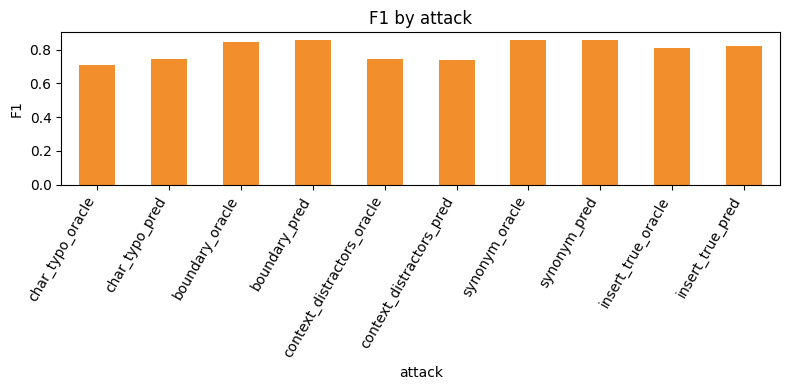

In [197]:
import os
os.makedirs('reports/figures', exist_ok=True)

ax = results_df['f1'].plot(kind='bar', color=['#4f81bd' if i=='baseline' else '#f28e2b' for i in results_df.index])
ax.set_ylabel('F1')
ax.set_title('F1 by attack')
plt.xticks(rotation=60, ha='right')
plt.tight_layout()
plt.show()



## Qualitative examples
Before/after comparisons (oracle and pred-guided).


In [198]:
SAMPLE_IDXS = [0, 2, 5]

def format_tokens(tokens: List[str], labels: List[str]) -> str:
    return ' '.join(f"{t}/{l}" for t, l in zip(tokens, labels))


def show_examples(attack_name: str, sample_indices=SAMPLE_IDXS):
    print(f"=== Attack: {attack_name} ===")
    atk_tokens = attack_runs[attack_name]['tokens']
    atk_preds = attack_runs[attack_name]['preds']
    for idx in sample_indices:
        orig_tokens = base_orig[idx]
        gold = golds[idx]
        base_pred = base_preds[idx]
        attacked_tok = atk_tokens[idx]
        attacked_pred = atk_preds[idx]
        print(f"Example {idx}")
        print("Gold:     ", format_tokens(orig_tokens, gold))
        print("Baseline: ", format_tokens(orig_tokens, base_pred))
        print("Attacked: ", format_tokens(attacked_tok, attacked_pred))
        diffs = [i for i, (g, a) in enumerate(zip(gold, attacked_pred)) if i < len(attacked_pred) and g != a]
        if diffs:
            print(f"Changed positions: {diffs}")
        else:
            print("No changes on gold spans.")

for name in attack_runs:
    if name == 'baseline':
        continue
    show_examples(name)



=== Attack: char_typo_oracle ===
Example 0
Gold:      E/O M/O E/O N/O T/O A/O Órgão/O :/O 8ª/B-ORGANIZACAO TURMA/I-ORGANIZACAO CÍVEL/I-ORGANIZACAO Classe/O :/O APELAÇÃO/O CÍVEL/O N/O ./O Processo/O :/O 20150110436469APC/B-JURISPRUDENCIA (/O 0012843-03.2015.8.07.0001/B-JURISPRUDENCIA )/O Apelante/O (/O s/O )/O :/O BRASILIA/B-ORGANIZACAO CURSOS/I-ORGANIZACAO E/I-ORGANIZACAO CONCURSOS/I-ORGANIZACAO LTDA/I-ORGANIZACAO GRANCURSOS/I-ORGANIZACAO ESCOLA/I-ORGANIZACAO PARA/I-ORGANIZACAO CONCURSOS/I-ORGANIZACAO PUBLICOS/I-ORGANIZACAO LTDA/O Apelado/O (/O s/O )/O :/O ALISSON/B-PESSOA SILVA/I-PESSOA BATISTA/I-PESSOA DE/I-PESSOA MORAES/I-PESSOA Relatora/O :/O Desembargadora/O NÍDIA/B-PESSOA CORRÊA/I-PESSOA LIMA/I-PESSOA Acórdão/B-JURISPRUDENCIA N./I-JURISPRUDENCIA :/I-JURISPRUDENCIA 1082726/I-JURISPRUDENCIA CIVIL/O E/O PROCESSUAL/O CIVIL/O ./O
Baseline:  E/O M/O E/O N/O T/O A/O Órgão/O :/O 8ª/B-ORGANIZACAO TURMA/I-ORGANIZACAO CÍVEL/I-ORGANIZACAO Classe/O :/O APELAÇÃO/O CÍVEL/O N/O ./O Processo/O :/

> Note: for true insertion attacks, the attacked sequence is longer than the original. We therefore inspect examples using
local windows around mapped entity positions (rather than printing full token/label pairs 1-to-1).


## Ranking: most damaging attacks
We rank attacks by `delta_f1` (lower is worse) to highlight the model's main vulnerabilities.

## Discussion
- Oracle attacks (gold spans) are worst-case and show maximum vulnerability when anchors are known.
- Pred-guided attacks are more realistic; still reveal sensitivity to anchor corruption and boundary changes.
- Typo and insertion attacks hit entity anchors hardest, aligning with robustness drops under character noise and insertion.
- Boundary perturbations hurt because punctuation/structure act as delimiters (as seen in interpretability).
- Context distractors dilute anchor focus, mirroring robustness collapse under word insertion.
- Synonyms are mild: semantics preserved, matching small robustness drops.

Hardening ideas: targeted augmentation with typos/boundaries/distractors, adversarial training on anchor corruption, and exploring char/byte-aware tokenization to reduce surface-form brittleness.


## Key Takeaways

1. Character-level and contextual attacks significantly degrade both confidence
   and structural integrity of entity predictions.
2. Boundary attacks cause a small but consistent degradation, stronger under oracle spans; synonyms are nearly unaffected, confirming findings from robustness and interpretability analyses.
3. Word insertion does not fully erase entities, but:
   - disrupts span boundaries,
   - reduces confidence,
   - and breaks alignment assumptions used by standard NER evaluation.
   - Note: this insertion protocol differs from Stage 2 ‘random word insertion’ (global clutter). Here we insert locally near spans, so overall F1 degrades less, but span recovery/retention reveals structural fragility

Overall, the model is **semantically robust but structurally fragile**, relying
heavily on clean token order and stable boundary cues.
